In [2]:
import pandas as pd

N = 20
variants = ['height','mass','income','iq','pages','age','bmi','work_exp','friends','test_time']
df = pd.read_csv("../datasets/students_simple.csv")
X = df[variants[N % 5]]
Y = df[variants[N * N % 5 + 5]]




1. Расчет корреляций  
1.1 Фехнера  

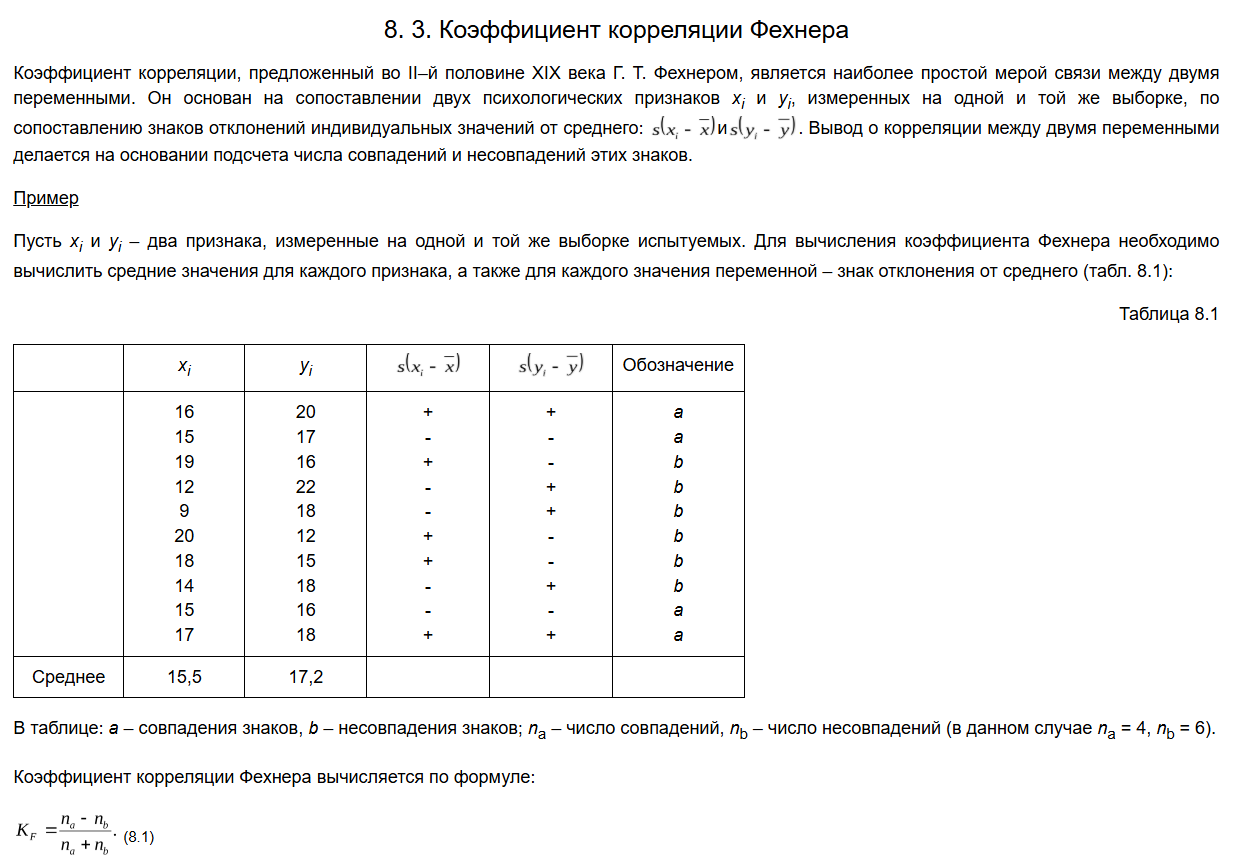

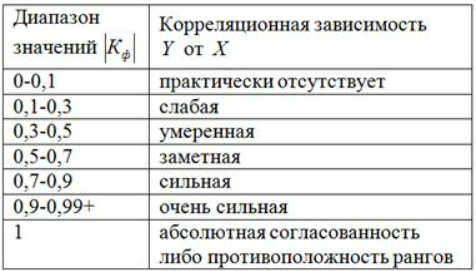

In [3]:
x_mean = X.mean()
y_mean = Y.mean()
n_same, n_diff = 0, 0
for x, y in zip(X, Y):
    x_diff = x - x_mean
    y_diff = y - y_mean
    if x_diff > 0 and y_mean > 0 or x_diff <= 0 and y_diff <= 0:
        n_same += 1
    else:
        n_diff += 1

Kf = (n_same - n_diff)/(n_same + n_diff)
print(f'Коэффициент Фехнера = {Kf}')

Коэффициент Фехнера = 0.6


1.2 Пирсона + доверительный интервал

насколько отклонения 𝑋 от своего среднего совпадают с отклонениями 𝑌 от своего среднего

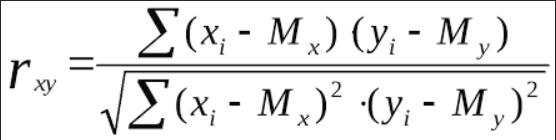

Он принимает значения от -1 до +1. Значение коэффициента +1 означает наличие полной положительной линейной связи, а значение -1 – наличие полной отрицательной линейной связи.

In [4]:
from scipy import stats
import math

s_x = (sum((x - x_mean)**2 for x in X))**0.5
s_y = (sum((y - y_mean)**2 for y in Y))**0.5
r_xy = sum((x - x_mean) * (y - y_mean) for x, y in zip(X, Y)) / (s_x * s_y)
print(f'Коэффициент Пирсона = {r_xy:.2f}')

n = len(X)
confidence=0.95

# Преобразование Фишера
z = math.atanh(r_xy)  

# Стандартная ошибка
se = 1 / math.sqrt(n - 3)

# Критическое значение Z
z_critical = stats.norm.ppf((1 + confidence) / 2)

# Доверительный интервал в z-пространстве
z_lower = z - z_critical * se
z_upper = z + z_critical * se

# Обратное преобразование в r-пространство
r_lower = math.tanh(z_lower)
r_upper = math.tanh(z_upper)

print(f'\nДоверительный интервал 95%:')
print(f'Интервал: [{r_lower:.2f}, {r_upper:.2f}]')



r_pearson, p_pearson = stats.pearsonr(X, Y)
print(f"Pearson: r = {r_pearson:.2f}, p = {p_pearson:.2g}")




Коэффициент Пирсона = 0.19

Доверительный интервал 95%:
Интервал: [-0.27, 0.59]
Pearson: r = 0.19, p = 0.41


3. Спирмена

коэффициент корреляции рангов

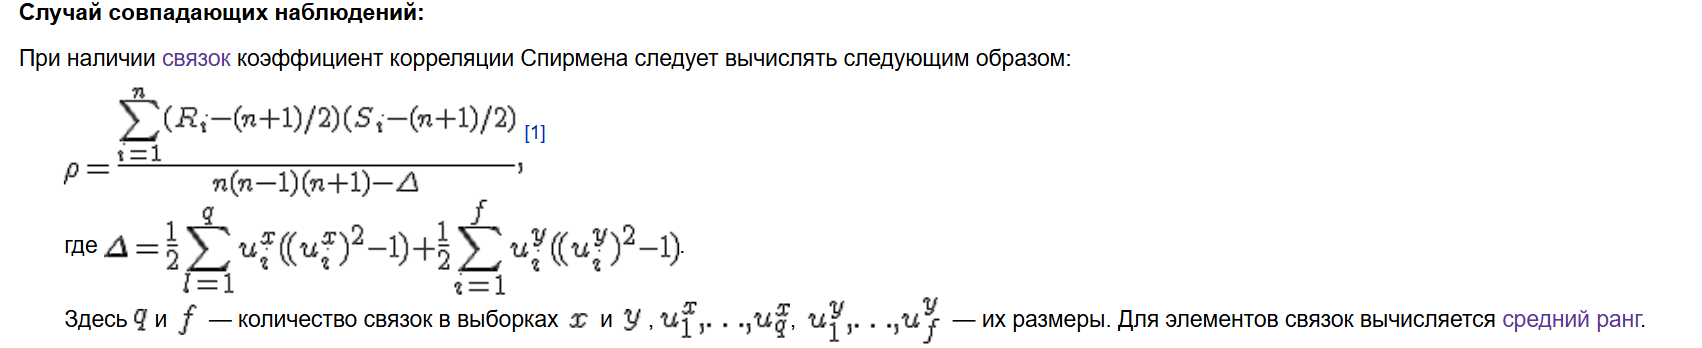

In [5]:


def count_ranks_and_ties(X):
    sorted_x = sorted(enumerate(X), key=lambda x: x[1])
    ranks = [0] * len(sorted_x)
    i = 0
    u_y=[]
    while i < len(sorted_x):
        start = i
        i += 1
        while i < len(sorted_x) and sorted_x[start][1] == sorted_x[i][1]:
            i += 1
        
        avg_rank = (start + i + 1)/2

        for j in range(start, i):
            ranks[sorted_x[j][0]] = avg_rank
        count = i - start
        
        if count > 1:
            u_y.append(count)
            
    return ranks, u_y

ranks_X, u_X = count_ranks_and_ties(X)
ranks_Y, u_Y = count_ranks_and_ties(Y)


n = len(ranks_X)

delta = sum(u_x * (u_x * u_x - 1) for u_x in u_X) + sum(u_y * (u_y * u_y - 1) for u_y in u_Y)
delta /= 2
spearman = sum((r_x - (n + 1)/2)*(r_y - (n + 1)/2) for r_x, r_y in zip(ranks_X, ranks_Y))/(n * (n - 1) * (n + 1) - delta)
print(f'Коэффициент Спирмана: {spearman}')



Коэффициент Спирмана: 0.014584915211338902


In [6]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(X, Y)

print(f"Spearman correlation: {rho:.4f}")
print(f"P-value: {p_value:.4f}")

Spearman correlation: 0.1750
P-value: 0.4605


4. Кенделла

Он оценивает, как часто при увеличении одной переменной увеличивается (или уменьшается) другая переменная.


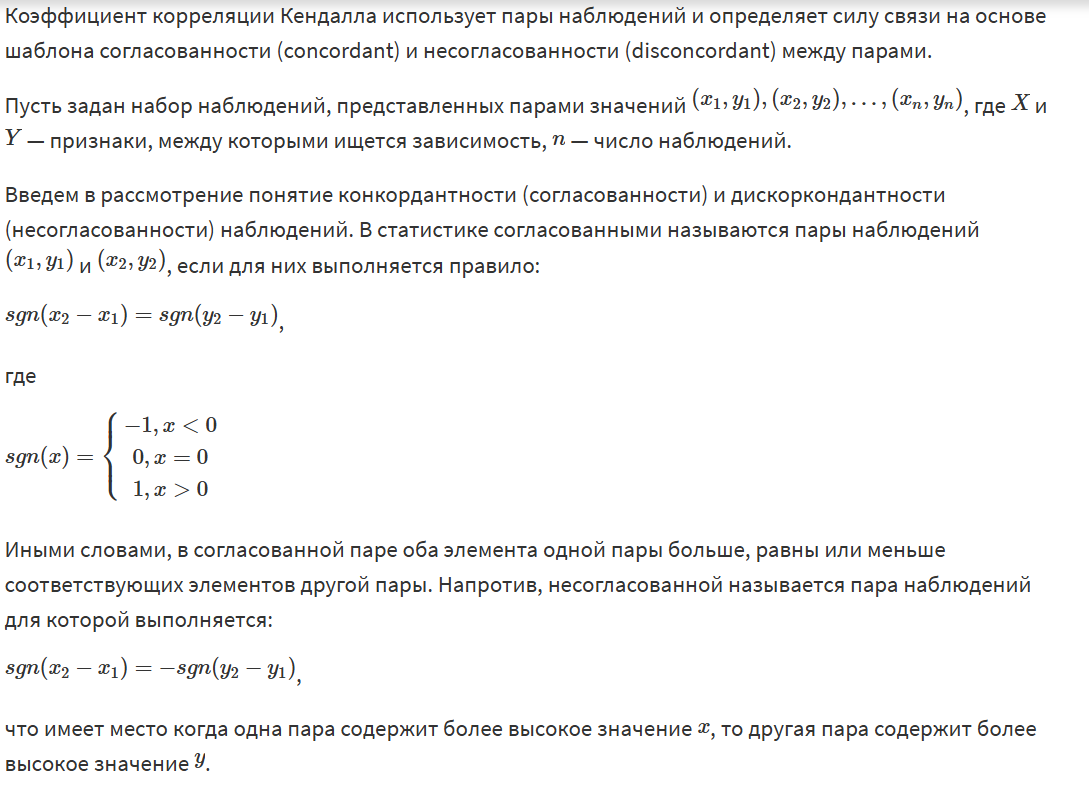

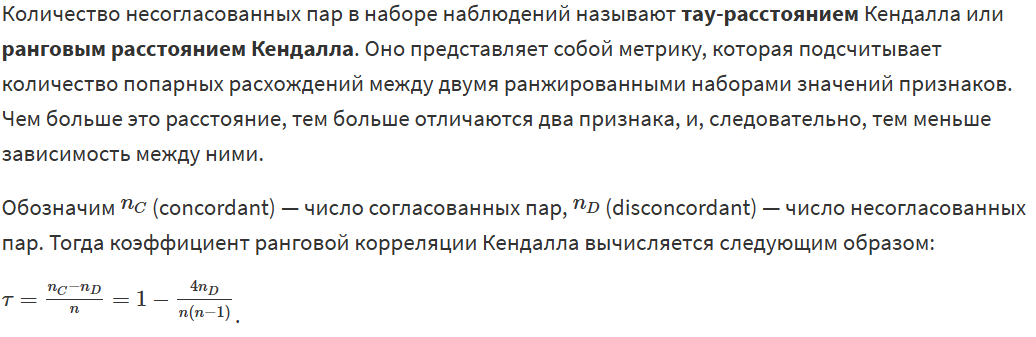

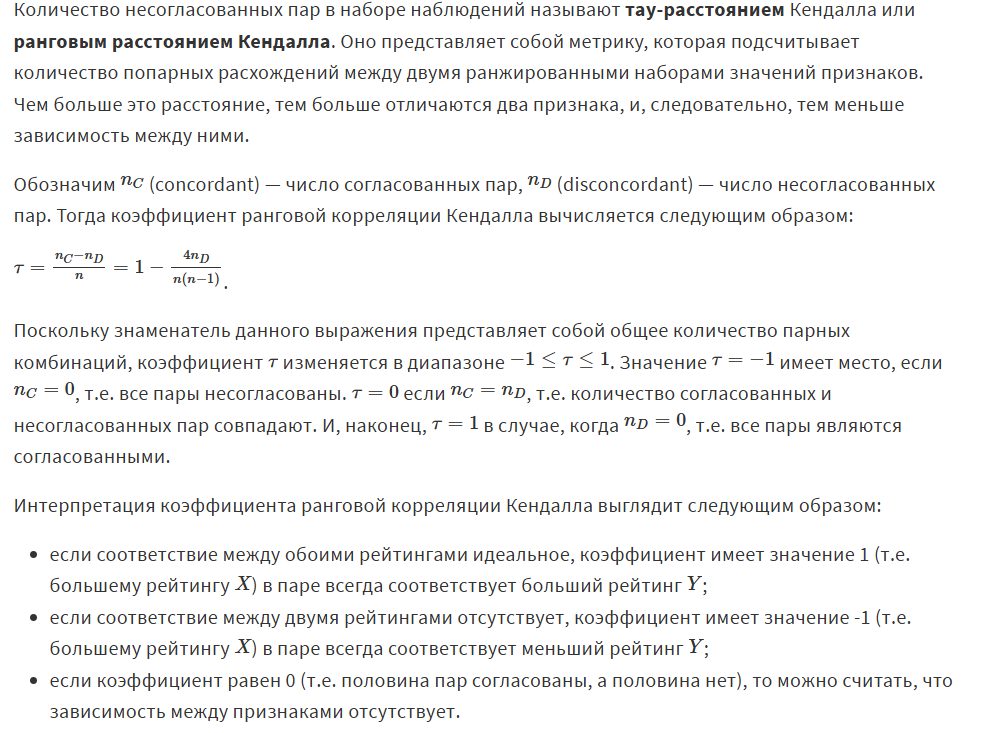

In [7]:
import numpy as np
from itertools import combinations
from scipy.stats import kendalltau

nd = sum(1 if np.sign(x2 - x1) == -np.sign(y2 - y1) else 0 for (x1, y1), (x2, y2) in combinations(zip(X, Y), 2))

kendell = 1 - 4 * nd / (n * (n - 1))
print(f'Коэффициент кенделла: {kendell}')

tau_kendall, p_kendall = kendalltau(X, Y)
print(f"Kendall: tau = {tau_kendall:.4f}, p = {p_kendall:.4g}")


Коэффициент кенделла: 0.2210526315789474
Kendall: tau = 0.1223, p = 0.4698


## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

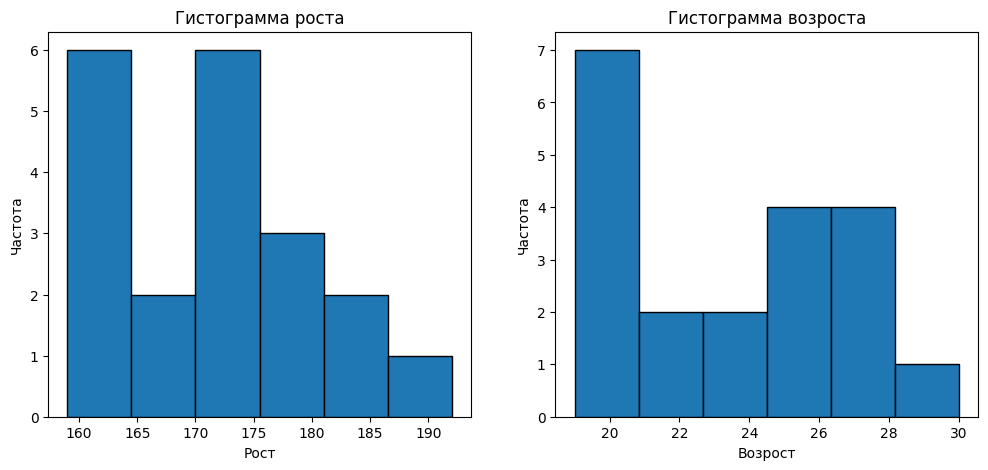

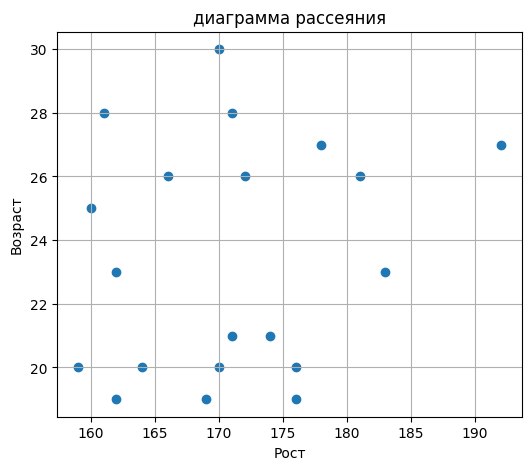

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(X, bins='auto', edgecolor='black')
plt.title(f"Гистограмма роста")
plt.xlabel("Рост")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
plt.hist(Y, bins='auto', edgecolor='black')
plt.title(f"Гистограмма возроста")
plt.xlabel("Возрост")
plt.ylabel("Частота")


plt.figure(figsize=(6, 5))
plt.scatter(X, Y)
plt.xlabel("Рост")
plt.ylabel("Возраст")
plt.title(f'диаграмма рассеяния')
plt.grid(True)
plt.show()


plt.tight_layout()
plt.show()

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$

w1: 0.082
w0: 9.347
R^2: 0.038


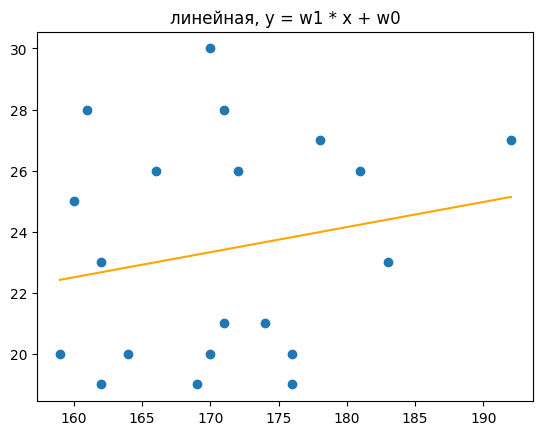

In [9]:
A = np.vstack([X, np.ones(len(X))]).T

w1, w0 = np.linalg.lstsq(A, Y)[0]

print(f"w1: {w1:.3f}")
print(f"w0: {w0:.3f}")

predicted_Y_linear = w1*X+w0

def r2(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    ss_res = np.sum((y_true - y_pred) ** 2)  
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  
    return 1 - (ss_res / ss_tot)

print(f"R^2: {r2(Y, predicted_Y_linear):.3f}")

plt.scatter(X, Y)
plt.plot(X, predicted_Y_linear, color="orange")
plt.title("линейная, y = w1 * x + w0")
plt.show()

2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$

w2: 0.005
w1: -1.771
w0: 169.689
R^2: 0.056


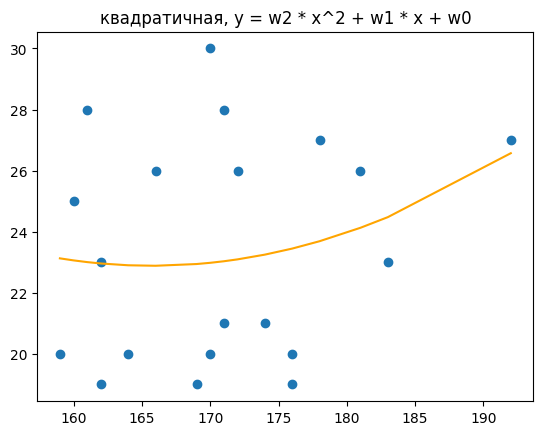

In [11]:
A = np.vstack([X*X,X, np.ones(len(X))]).T

w2, w1, w0 = np.linalg.lstsq(A, Y)[0]

print(f"w2: {w2:.3f}")
print(f"w1: {w1:.3f}")
print(f"w0: {w0:.3f}")


predicted_Y_quadratic = w2*X*X + w1*X + w0

print(f"R^2: {r2(Y, predicted_Y_quadratic):.3f}")

plt.scatter(X, Y)
plt.plot(X, predicted_Y_quadratic, color="orange")
plt.title("квадратичная, y = w2 * x^2 + w1 * x + w0")
plt.show()

3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 

w1: -2351.711
w0: 37.197
R^2: 0.035


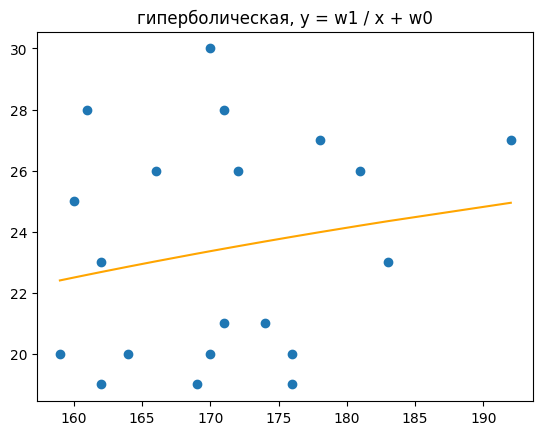

In [12]:
# z = 1/x -> y = w1 * z + w0
A = np.vstack([1/X, np.ones(len(X))]).T

w1, w0 = np.linalg.lstsq(A, Y)[0]

print(f"w1: {w1:.3f}")
print(f"w0: {w0:.3f}")

predicted_Y_hyperbolic = w1/X + w0

print(f"R^2: {r2(Y, predicted_Y_hyperbolic):.3f}")

plt.scatter(X, Y)
plt.plot(X, predicted_Y_hyperbolic, color="orange")
plt.title("гиперболическая, y = w1 / x + w0")
plt.show()

4. показательная, $y = w_1^x \cdot w_0$

w1: 1.004
w0: 12.475
R^2: 0.034


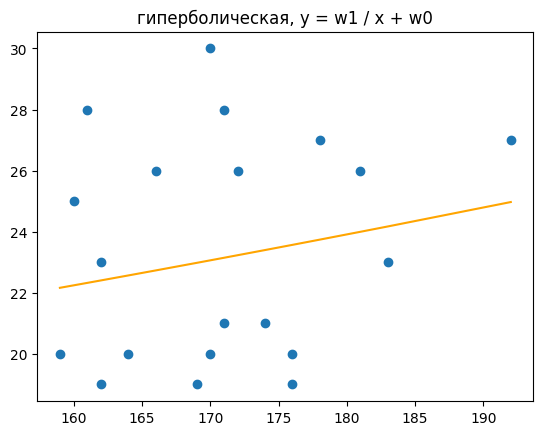

In [13]:
# ln(y) = x * ln(w1) + ln(w0)
import math
A = np.vstack([X, np.ones(len(X))]).T

log_w1, log_w0 = np.linalg.lstsq(A, np.log(Y))[0]
w1 = math.exp(log_w1)
w0 = math.exp(log_w0)
print(f"w1: {w1:.3f}")
print(f"w0: {w0:.3f}")
predicted_Y_exponential = w1**X * w0

print(f"R^2: {r2(Y, predicted_Y_exponential):.3f}")

plt.scatter(X, Y)
plt.plot(X, predicted_Y_exponential, color="orange")
plt.title("гиперболическая, y = w1 / x + w0")
plt.show()

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера


Нулевая гипотеза (H_0): модель не лучше, чем константа

Альтернатива (H_1): модель объясняет значительную часть вариации y

In [25]:
from scipy.stats import f
def fisher_test(Y_raw, predicted_Y_raw, k, alpha=0.05):
    n = len(Y_raw)
    Y = np.asarray(Y_raw)
    predicted_Y = np.asarray(predicted_Y_raw)
    ss_tot = np.sum((Y - Y.mean())**2)
    ss_res = np.sum((Y - predicted_Y)**2)
    ss_reg = ss_tot - ss_res

    df_reg = k - 1
    df_res = n - k
    F = ss_reg * df_res / (ss_res * df_reg)

    p_value = 1 - f.cdf(F, df_reg, df_res)

    print(f'F = {F:.3f}')
    print(f'p_value = {p_value:.3f}')

    if p_value < alpha:
        print("результат статистически значим -> модель лучше чем константа")
    else:
        print("резльтат статистически не значим -> модель не лучше чем константа")


print("тест фишера для линейной регрессии")
fisher_test(Y, predicted_Y_linear, 2)
print("\n")

print("тест фишера для квадратичной регрессии")
fisher_test(Y, predicted_Y_quadratic, 3)
print("\n")

print("тест фишера для гиперболической регрессии")
fisher_test(Y, predicted_Y_hyperbolic, 2)
print("\n")

print("тест фишера для показательной регрессии")
fisher_test(Y, predicted_Y_exponential, 2)
print("\n")

тест фишера для линейной регрессии
F = 0.707
p_value = 0.412
резльтат статистически не значим -> модель не лучше чем константа


тест фишера для квадратичной регрессии
F = 0.503
p_value = 0.613
резльтат статистически не значим -> модель не лучше чем константа


тест фишера для гиперболической регрессии
F = 0.647
p_value = 0.432
резльтат статистически не значим -> модель не лучше чем константа


тест фишера для показательной регрессии
F = 0.626
p_value = 0.439
резльтат статистически не значим -> модель не лучше чем константа


